# D(isaggregator): Load & PV model

* __case 1:__ Load from London and PVGIS data
* __case 2:__ Load from London and Grafana data
* __case 3:__ Load from London, PV from Grafana, and exogenous data from PVGIS

In [1]:
#choose case
CASE = 2
# train or used trained models
TRAIN = True

maxLoad = 5.181

if CASE == 1:
    maxPV = 0.8165
else:
    maxPV = 1.41332

In [2]:
import os

os.environ['CASE'] = str(CASE)
os.environ['MAXPV'] = str(maxPV)
os.environ['MAXLOAD'] = str(maxLoad)
RES_DIR = f'results/case0{CASE}'
os.environ['RES_DIR'] = RES_DIR
MOD_DIR = f'saved_models/case0{CASE}'
os.environ['MOD_DIR'] = MOD_DIR

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

In [3]:
import pandas as pd
import numpy as np

from modelUtils import *
from D import D

df = pd.read_csv(f'../data/case0{CASE}/case0{CASE}_01.csv', index_col=0)

results = pd.DataFrame(
    index=[
        'full-year','day-only','6-month','season',
        '2-month', '1-month', '2-week', '1-week'
    ],
    columns=['pv-rmse','load-rmse','hb-pv-rmse','hb-load-rmse']
)

model = D(
    maxPV = maxPV,
    maxLoad = maxLoad,
    hidden_layer_sizes=3*[9],
    learning_rate_init=0.001,
    batch_size=32,
    max_iter=400
)

## full-year

In [4]:
name = 'full-year'

if TRAIN:
    res, model = train_full(df, results, name, model)
    save_model(model, MOD_DIR, f'{name}_case{CASE}')
    print(res)

{'pv_mean': 4.24, 'pv_std': 2.32, 'load_mean': 1.38, 'load_std': 0.74}


## Day only

In [5]:
name = 'day-only'

dayOnly = getDayOnly(df)

if TRAIN:
    res, model = train_full(dayOnly, results, name, model)
    save_model(model, MOD_DIR, f'{name}_case{CASE}')
    print(res)

{'pv_mean': 5.05, 'pv_std': 2.6, 'load_mean': 1.55, 'load_std': 0.76}


## 6 months

In [6]:
name = '6-month'
mask = df.index.month.isin([1,3,5,7,9,11])

if TRAIN:
    train_df = df[mask]
    res, model = train_reduced(train_df, results, name, model)
    save_model(model, MOD_DIR, f'{name}_case{CASE}')
    print(res)
else:
    model = load_model(MOD_DIR, f'{name}_case{CASE}')

{'pv_mean': 3.5, 'pv_std': 1.01, 'load_mean': 1.21, 'load_std': 0.47}


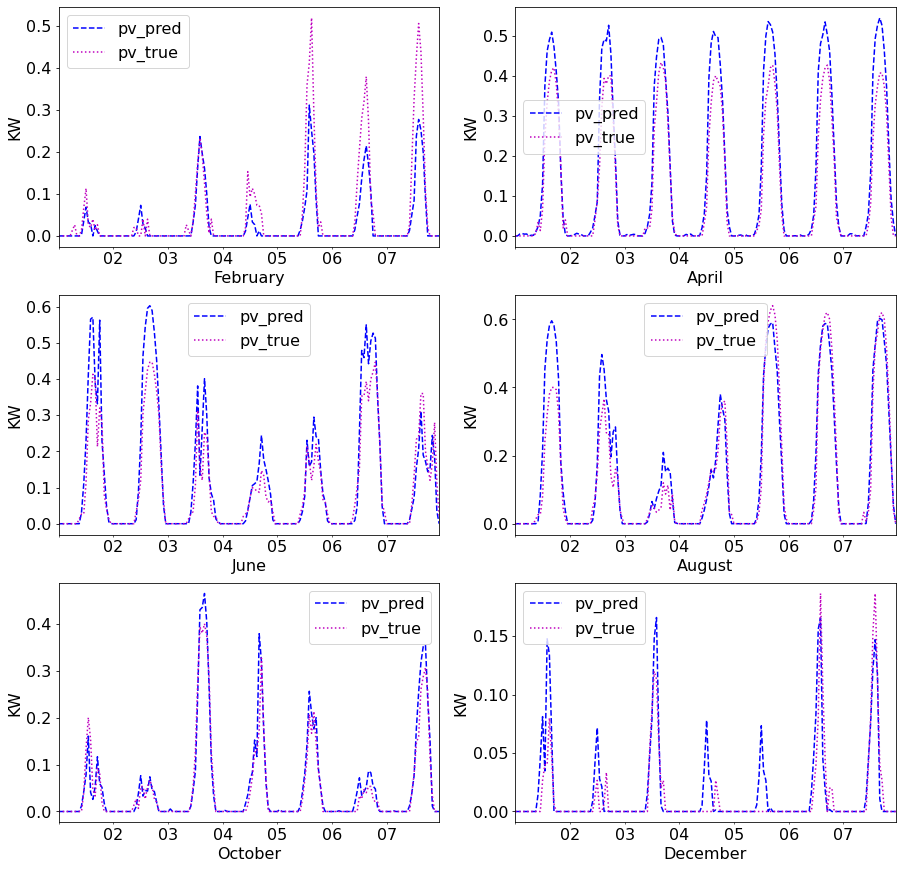

In [7]:
hb_df = df[~mask]
pv_pr, load_pr, X, y = test_hb(df, results, name, model)

plot = get_res_df(X, y, pv_pr, load_pr)
fig, ax = plt.subplots(3, 2, figsize=(15,15))

j = 0
for i in [2,4,6,8,10,12]:
    data = plot[plot.index.month == i][['pv_pred','pv_true']][0:7*24]
    a = data.plot(ax=ax[int(j/2)][j%2], style=['b--','m:'])
    a.set_ylabel("KW")
    a.set_xlabel(data.index[0].strftime('%B'))
    a.set_xticks([])
    j += 1

plt.savefig(f'{RES_DIR}/case0{CASE}_6m_pv_plot.png')
plt.show();

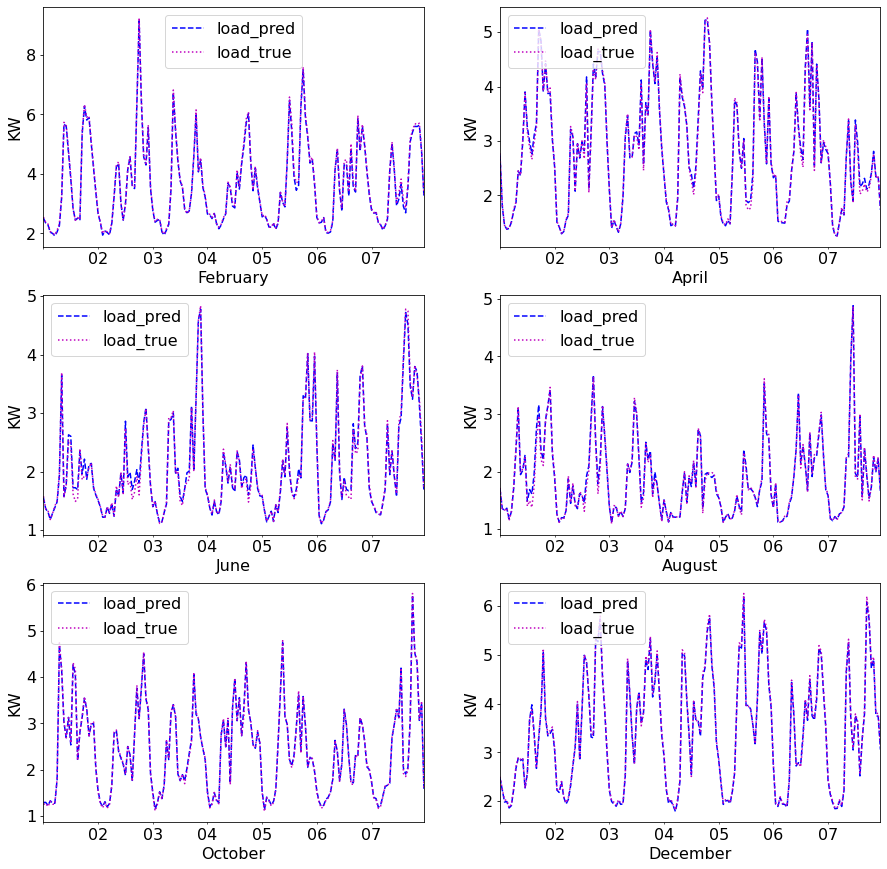

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))

j = 0
for i in [2,4,6,8,10,12]:
    data = plot[plot.index.month == i][['load_pred','load_true']][0:7*24]
    a = data.plot(ax=ax[int(j/2)][j%2], style=['b--','m:'])
    a.set_ylabel("KW")
    a.set_xlabel(data.index[0].strftime('%B'))
    a.set_xticks([])
    j += 1
    
plt.savefig(f'{RES_DIR}/case0{CASE}_6m_load_plot.png')
plt.show();

## Season

In [9]:
name = 'season'
mask = df.index.month.isin([2,5,8,11])

if TRAIN:
    train_df = df[mask]
    res, model = train_reduced(train_df, results, name, model)
    save_model(model, MOD_DIR, f'{name}_case{CASE}')
    print(res)
else:
    model = load_model(MOD_DIR, f'{name}_case{CASE}')

{'pv_mean': 3.77, 'pv_std': 1.08, 'load_mean': 1.14, 'load_std': 0.36}


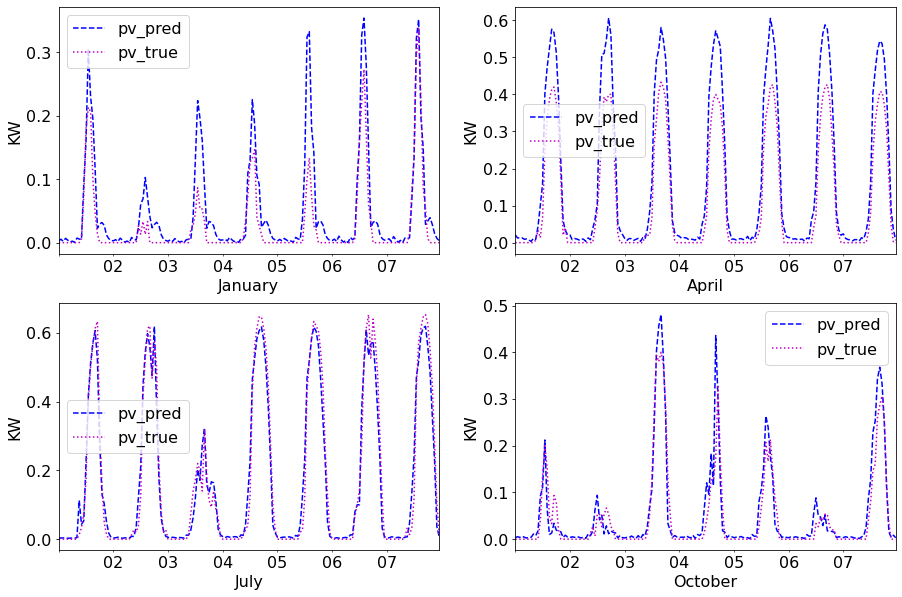

In [10]:
hb_df= df[~mask]
pv_pr, load_pr, X, y = test_hb(hb_df, results, name, model)

plot = get_res_df(X, y, pv_pr, load_pr)
fig, ax = plt.subplots(2, 2, figsize=(15,10))

j = 0
for i in [1,4,7,10]:
    data = plot[plot.index.month == i][['pv_pred','pv_true']][0:7*24]
    a = data.plot(ax=ax[int(j/2)][j%2], style=['b--','m:'])
    a.set_ylabel("KW")
    a.set_xlabel(data.index[0].strftime('%B'))
    a.set_xticks([])
    j += 1
    
plt.savefig(f'{RES_DIR}/case0{CASE}_season_pv_plot.png')
plt.show();

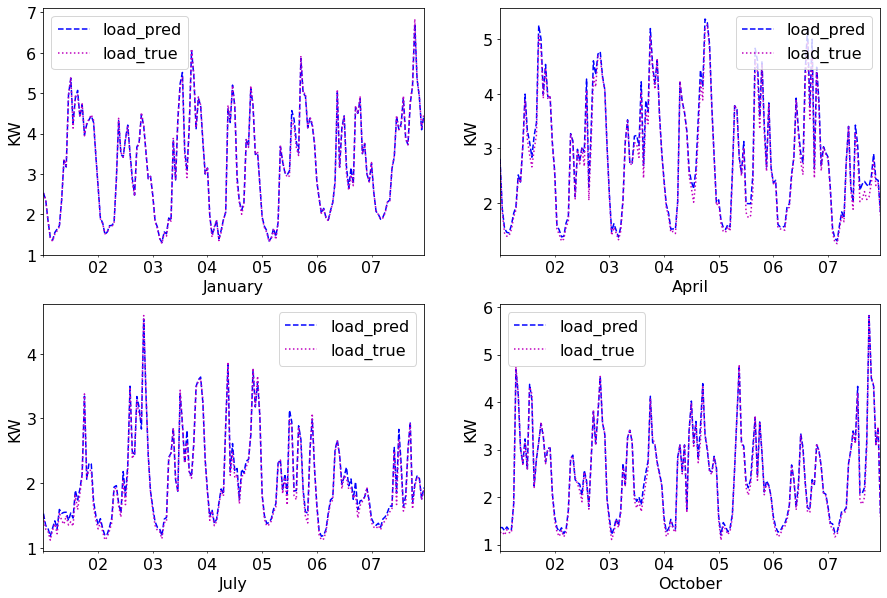

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))

j = 0
for i in [1,4,7,10]:
    data = plot[plot.index.month == i][['load_pred','load_true']][0:7*24]
    a = data.plot(ax=ax[int(j/2)][j%2], style=['b--','m:'])
    a.set_ylabel("KW")
    a.set_xlabel(data.index[0].strftime('%B'))
    a.set_xticks([])
    j += 1
    
plt.savefig(f'{RES_DIR}/case0{CASE}_season_load_plot.png')
plt.show();

## 2 months (Winter & Summer)

In [12]:
name = '2-month'
mask = df.index.month.isin([2,8])

if TRAIN:
    train_df = df[mask]
    res, model = train_reduced(train_df, results, name, model)
    save_model(model, MOD_DIR, f'{name}_case{CASE}')
    print(res)
else:
    model = load_model(MOD_DIR, f'{name}_case{CASE}')

{'pv_mean': 3.24, 'pv_std': 0.84, 'load_mean': 1.44, 'load_std': 0.38}


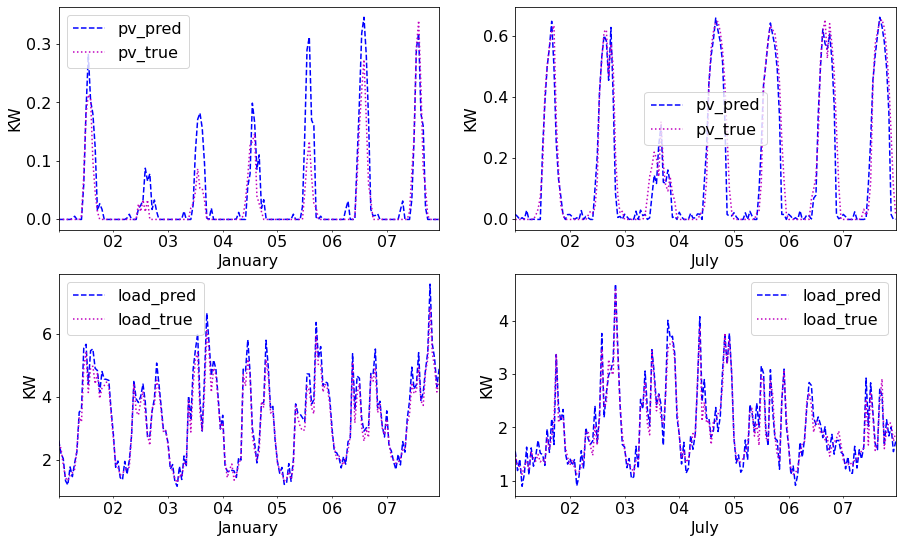

In [13]:
hb_df = df[~mask]
pv_pr, load_pr, X, y = test_hb(hb_df, results, name, model)

plot = get_res_df(X, y, pv_pr, load_pr)
fig, ax = plt.subplots(2, 2, figsize=(15,9))

a = plot[plot.index.month == 1][['pv_pred','pv_true']][0:7*24].plot(ax=ax[0][0], style=['b--','m:'])
a.set_ylabel("KW")
a.set_xlabel('January')
a.set_xticks([])
a = plot[plot.index.month == 7][['pv_pred','pv_true']][0:7*24].plot(ax=ax[0][1], style=['b--','m:'])
a.set_ylabel("KW")
a.set_xlabel('July')
a.set_xticks([])
a = plot[plot.index.month == 1][['load_pred','load_true']][0:7*24].plot(ax=ax[1][0], style=['b--','m:'])
a.set_ylabel("KW")
a.set_xlabel('January')
a.set_xticks([])
a = plot[plot.index.month == 7][['load_pred','load_true']][0:7*24].plot(ax=ax[1][1], style=['b--','m:']);
a.set_ylabel("KW")
a.set_xlabel('July')
a.set_xticks([])

plt.savefig(f'{RES_DIR}/case0{CASE}_2m_plot.png')
plt.show();

## 1 month

In [14]:
name = '1-month'

if TRAIN:
    temp_res = {
        'pv': [],
        'load': [],
        'hb_pv': [],
        'hb_load': []
    }

    for month in range(1,13):
        mask = df.index.month.isin([month])
        train_df = df[mask]
        res, model = train_reduced(train_df, results, name, model)

        temp_res['pv'].append(res['pv_mean'])
        temp_res['load'].append(res['load_mean'])

        hb_df = df[~mask]
        test_hb(df, results, name, model)

        temp_res['hb_pv'].append(results.loc[name, 'hb-pv-rmse'])
        temp_res['hb_load'].append(results.loc[name, 'hb-load-rmse'])

    results.loc[name, 'pv-rmse'] = np.mean(temp_res['pv'])
    results.loc[name, 'load-rmse'] = np.mean(temp_res['load'])
    results.loc[name, 'hb-pv-rmse'] = np.mean(temp_res['hb_pv'])
    results.loc[name, 'hb-load-rmse'] = np.mean(temp_res['hb_load'])
    
    mask = df.index.month.isin([4])
    train_df = df[mask]
    _, model = train_reduced(train_df, results, name, model)
    save_model(model, MOD_DIR, f'{name}_case{CASE}')
    
else:
    model = load_model(MOD_DIR, f'{name}_case{CASE}')
    hb_df = df[~(df.index.month.isin([4]))]

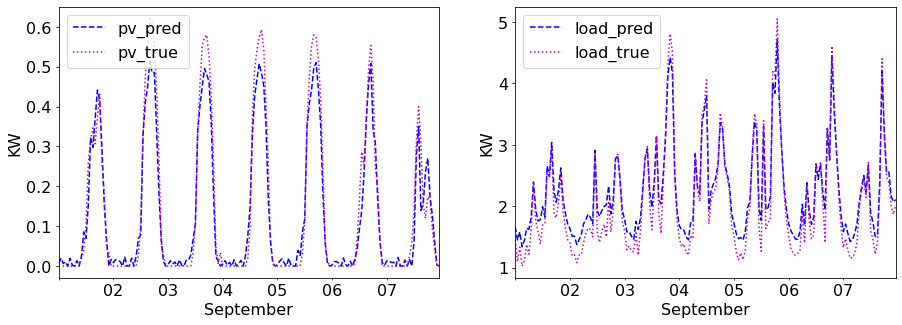

In [15]:
pv_pr, load_pr, X, y = test_hb(hb_df, results, name, model)

plot = get_res_df(X, y, pv_pr, load_pr)
plot = plot[plot.index.month == 9]
fig, ax = plt.subplots(1, 2, figsize=(15,5))

a = plot[['pv_pred','pv_true']][0:7*24].plot(ax=ax[0], style=['b--','m:'])
a.set_ylabel("KW")
a.set_xlabel('September')
a.set_xticks([])
a = plot[['load_pred','load_true']][0:7*24].plot(ax=ax[1], style=['b--','m:']);
a.set_ylabel("KW")
a.set_xlabel('September')
a.set_xticks([])

plt.savefig(f'{RES_DIR}/case0{CASE}_1m_plot.png')
plt.show();

## 2 week

In [16]:
name = '2-week'
df_2week = df.copy()
df_2week['nb_week'] = df_2week.index.strftime('%U')
df_2week['nb_week'] = pd.to_numeric(df_2week['nb_week'])

if TRAIN:
    temp_res = {
        'pv': [],
        'load': [],
        'hb_pv': [],
        'hb_load': []
    }

    for week in range(1,27):
        mask = (df_2week['nb_week'] == week) | (df_2week['nb_week'] == (week + 26))

        train_df = df_2week[mask].drop(columns=['nb_week'])
        res, model = train_reduced(train_df, results, name, model)

        temp_res['pv'].append(res['pv_mean'])
        temp_res['load'].append(res['load_mean'])

        hb_df = df_2week[~mask].drop(columns=['nb_week'])
        test_hb(hb_df, results, name, model)

        temp_res['hb_pv'].append(results.loc[name, 'hb-pv-rmse'])
        temp_res['hb_load'].append(results.loc[name, 'hb-load-rmse'])

    results.loc[name, 'pv-rmse'] = np.mean(temp_res['pv'])
    results.loc[name, 'load-rmse'] = np.mean(temp_res['load'])
    results.loc[name, 'hb-pv-rmse'] = np.mean(temp_res['hb_pv'])
    results.loc[name, 'hb-load-rmse'] = np.mean(temp_res['hb_load'])
    
    mask = (df_2week['nb_week'] == 14) | (df_2week['nb_week'] == (14 + 26))
    train_df = df_2week[mask].drop(columns=['nb_week'])
    _, model = train_reduced(train_df, results, name, model)
    save_model(model, MOD_DIR, f'{name}_case{CASE}')
    
else:
    model = load_model(MOD_DIR, f'{name}_case{CASE}')
    hb_df = df_2week[~((df_2week['nb_week'] == 14) | (df_2week['nb_week'] == (14 + 26)))].drop(columns=['nb_week'])

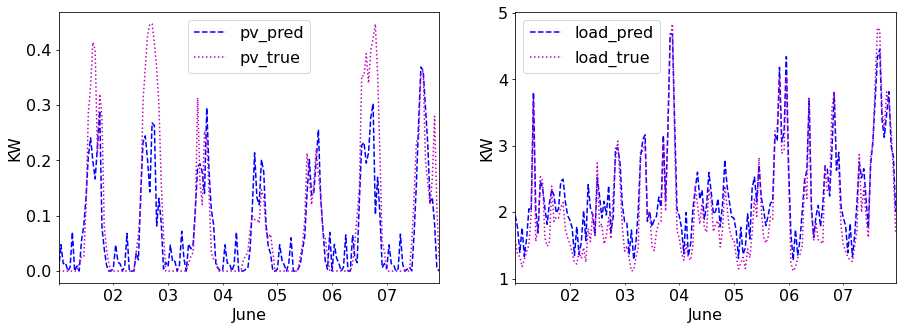

In [17]:
pv_pr, load_pr, X, y = test_hb(hb_df, results, name, model)
plot = get_res_df(X, y, pv_pr, load_pr)

plot = plot[plot.index.month == 6]

fig, ax = plt.subplots(1, 2, figsize=(15,5))
a = plot[['pv_pred','pv_true']][0:7*24].plot(ax=ax[0], style=['b--','m:'])
a.set_ylabel("KW")
a.set_xlabel('June')
a.set_xticks([])

a = plot[['load_pred','load_true']][0:7*24].plot(ax=ax[1], style=['b--','m:']);
a.set_ylabel("KW")
a.set_xlabel('June')
a.set_xticks([])

plt.savefig(f'{RES_DIR}/case0{CASE}_2w_plot.png')
plt.show();

## 1 week

In [18]:
name = '1-week'

df_1week = df.copy()
df_1week['nb_week'] = df_1week.index.strftime('%U')
df_1week['nb_week'] = pd.to_numeric(df_1week['nb_week'])

if TRAIN:
    temp_res = {
        'pv': [],
        'load': [],
        'hb_pv': [],
        'hb_load': []
    }

    for week in range(1, 54):
        mask = (df_1week['nb_week'] == week)

        train_df = df_1week[mask].drop(columns=['nb_week'])
        res, model = train_reduced(train_df, results, name, model)

        temp_res['pv'].append(res['pv_mean'])
        temp_res['load'].append(res['load_mean'])

        hb_df = df_1week[~mask].drop(columns=['nb_week'])
        test_hb(hb_df, results, name, model)

        temp_res['hb_pv'].append(results.loc[name, 'hb-pv-rmse'])
        temp_res['hb_load'].append(results.loc[name, 'hb-load-rmse'])

    results.loc[name, 'pv-rmse'] = np.mean(temp_res['pv'])
    results.loc[name, 'load-rmse'] = np.mean(temp_res['load'])
    results.loc[name, 'hb-pv-rmse'] = np.mean(temp_res['hb_pv'])
    results.loc[name, 'hb-load-rmse'] = np.mean(temp_res['hb_load'])
    
    mask = (df_1week['nb_week'] == 26)
    train_df = df_1week[mask].drop(columns=['nb_week'])
    _, model = train_reduced(train_df, results, name, model)
    save_model(model, MOD_DIR, f'{name}_case{CASE}')
    
else:
    model = load_model(MOD_DIR, f'{name}_case{CASE}')
    hb_df = df_1week[~((df_1week['nb_week'] == 26))].drop(columns=['nb_week'])

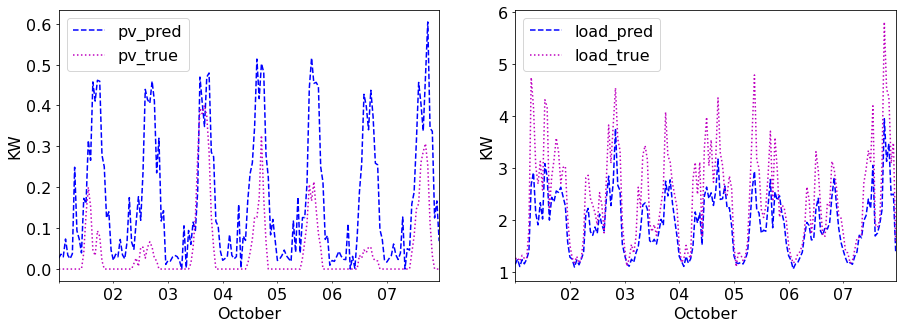

In [22]:
pv_pr, load_pr, X, y = test_hb(hb_df, results, name, model)
plot = get_res_df(X, y, pv_pr, load_pr)

plot = plot[plot.index.month == 10]

fig, ax = plt.subplots(1, 2, figsize=(15,5))
a = plot[['pv_pred','pv_true']][0:7*24].plot(ax=ax[0], style=['b--','m:'])
a.set_ylabel("KW")
a.set_xlabel('October')
a.set_xticks([])

a = plot[['load_pred','load_true']][0:7*24].plot(ax=ax[1], style=['b--','m:']);
a.set_ylabel("KW")
a.set_xlabel('October')
a.set_xticks([])

plt.savefig(f'{RES_DIR}/case0{CASE}_1w_plot.png')
plt.show();

In [23]:
if TRAIN:
    results.to_csv(f'{RES_DIR}/case0{CASE}_results.csv')
else:
    results = pd.read_csv(f'{RES_DIR}/case0{CASE}_results.csv', index_col=0)
    
results

,pv-rmse,load-rmse,hb-pv-rmse,hb-load-rmse
full-year,4.24,1.38,NaN,NaN
day-only,5.05,1.55,NaN,NaN
6-month,3.5,1.21,4.59,1.36
season,3.77,1.14,5.4,1.93
2-month,3.24,1.44,5.64,4.66
1-month,5.52,2.17,5.4,4.3
2-week,5.91,2.67,8.73,5.32
1-week,9.23,2.81,12.4,14.53


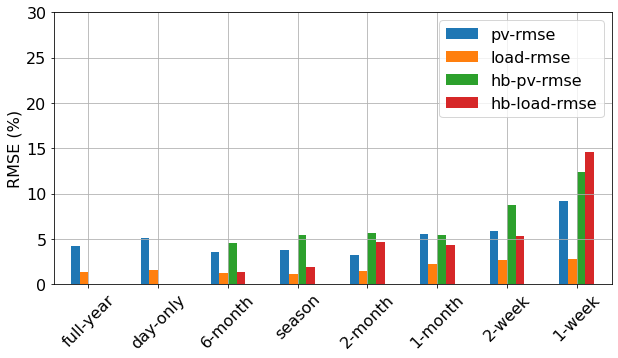

In [21]:
results.plot(
    kind='bar',
    figsize=(10,5),
    grid=True,
    yticks=[x for x in range(0,35,5)],
    ylabel='RMSE (%)',
    rot=45
)
plt.savefig(f'{RES_DIR}/plot_results.png')
plt.show();